<html class="no-js" dir="ltr" lang="hk" loc="zh-CN">
 <head>
  <meta charset="utf-8"/>
  <meta content="IE=edge,chrome=1" http-equiv="X-UA-Compatible"/>
  <title>
   WhatsApp
  </title>
  <meta content="width=device-width" name="viewport"/>
  <meta content="notranslate" name="google"/>
  <meta content="telephone=no" name="format-detection"/>
  <meta content="https://web.whatsapp.com/" name="og:url"/>
  <meta content="WhatsApp Web" name="og:title"/>
  <meta content="https://static.facebook.com/images/whatsapp/www/whatsapp-promo.png" name="og:image"/>
  <link href="/apple-touch-icon.png" rel="apple-touch-icon" sizes="194x194" type="image/png"/>
  <meta content="#111b21" media="(prefers-color-scheme: dark)" name="theme-color"/>
  <meta content="#f0f2f5" name="theme-color"/>
  <link crossorigin="use-credentials" href="/manifest.json" id="whatsapp-pwa-manifest-link" rel="manifest"/>
  <style>
   #initial_startup {
      --startup-background: #f0f2f5;
      --startup-background-rgb: 240, 242
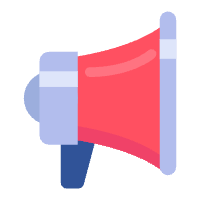

In [4]:
from tqdm import tqdm
import pickle
from utils import *
import tensorflow as tf

config = {
    # Data arguments
    'data.max_len_words': 200,
    'data.max_len_chars': 200,
    'data.max_len_subwords': 20,
    'data.data_dir': None,  # You can set the directory as a string here
    'data.delimit_mode': 1,
    'data.subword_dict_dir': None,  # Directory of subword dictionary
    'data.word_dict_dir': None,  # Directory of word dictionary
    'data.char_dict_dir': None,  # Directory of character dictionary

    # Model arguments
    'model.emb_dim': 32,
    'model.emb_mode': 1,

    # Test arguments
    'test.batch_size': 128,

    # Log arguments
    'log.output_dir': None,  # Directory to save test results
    'log.checkpoint_dir': None  # Directory of the learned model
}

# You can print the dictionary or access its values like this:
for key, val in config.items():
    print(f"{key}={val}")

urls, labels = read_data(config["data.data_dir"]) 
 
x, word_reverse_dict = get_word_vocab(urls, config["data.max_len_words"]) 
word_x = get_words(x, word_reverse_dict, config["data.delimit_mode"], urls) 

ngram_dict = pickle.load(open(config["data.subword_dict_dir"], "rb")) 
print("Size of subword vocabulary (train): {}".format(len(ngram_dict)))
word_dict = pickle.load(open(config["data.word_dict_dir"], "rb"))
print("size of word vocabulary (train): {}".format(len(word_dict)))
ngramed_id_x, worded_id_x = ngram_id_x_from_dict(word_x, config["data.max_len_subwords"], ngram_dict, word_dict) 
chars_dict = pickle.load(open(config["data.char_dict_dir"], "rb"))          
chared_id_x = char_id_x(urls, chars_dict, config["data.max_len_chars"])    

print("Number of testing urls: {}".format(len(labels)))

######################## EVALUATION ########################### 

def test_step(x, emb_mode):
    p = 1.0
    if emb_mode == 1: 
        feed_dict = {
            input_x_char_seq: x[0],
            dropout_keep_prob: p}  
    elif emb_mode == 2: 
        feed_dict = {
            input_x_word: x[0],
            dropout_keep_prob: p}
    elif emb_mode == 3: 
        feed_dict = {
            input_x_char_seq: x[0],
            input_x_word: x[1],
            dropout_keep_prob: p}
    elif emb_mode == 4: 
        feed_dict = {
            input_x_word: x[0],
            input_x_char: x[1],
            input_x_char_pad_idx: x[2],
            dropout_keep_prob: p}
    elif emb_mode == 5:  
        feed_dict = {
            input_x_char_seq: x[0],
            input_x_word: x[1],
            input_x_char: x[2],
            input_x_char_pad_idx: x[3],
            dropout_keep_prob: p}
    preds, s = sess.run([predictions, scores], feed_dict)
    return preds, s

checkpoint_file = config["log.checkpoint_dir"]
total_time = 0
graph = tf.Graph() 
with graph.as_default(): 
    session_conf = tf.ConfigProto(allow_soft_placement=True, log_device_placement=False)
    session_conf.gpu_options.allow_growth=True 
    sess = tf.Session(config=session_conf)
    with sess.as_default(): 
        saver = tf.train.import_meta_graph("{}.meta".format(checkpoint_file))
        saver.restore(sess, checkpoint_file) 
        
        if  config["model.emb_mode"] in [1, 3, 5]: 
            input_x_char_seq = graph.get_operation_by_name("input_x_char_seq").outputs[0]
        if config["model.emb_mode"] in [2, 3, 4, 5]:
            input_x_word = graph.get_operation_by_name("input_x_word").outputs[0]
        if config["model.emb_mode"] in [4, 5]:
            input_x_char = graph.get_operation_by_name("input_x_char").outputs[0]
            input_x_char_pad_idx = graph.get_operation_by_name("input_x_char_pad_idx").outputs[0]
        dropout_keep_prob = graph.get_operation_by_name("dropout_keep_prob").outputs[0] 

        predictions = graph.get_operation_by_name("output/predictions").outputs[0]
        scores = graph.get_operation_by_name("output/scores").outputs[0]
         
        if config["model.emb_mode"] == 1: 
            batches = batch_iter(list(chared_id_x), config["test.batch_size"], 1, shuffle=False) 
        elif config["model.emb_mode"] == 2: 
            batches = batch_iter(list(worded_id_x), config["test.batch_size"], 1, shuffle=False) 
        elif config["model.emb_mode"] == 3: 
            batches = batch_iter(list(zip(chared_id_x, worded_id_x)), config["test.batch_size"], 1, shuffle=False)
        elif config["model.emb_mode"] == 4: 
            batches = batch_iter(list(zip(ngramed_id_x, worded_id_x)), config["test.batch_size"], 1, shuffle=False)
        elif config["model.emb_mode"] == 5: 
            batches = batch_iter(list(zip(ngramed_id_x, worded_id_x, chared_id_x)), config["test.batch_size"], 1, shuffle=False)    
        all_predictions = []
        all_scores = []
        
        nb_batches = int(len(labels) / config["test.batch_size"])
        if len(labels) % config["test.batch_size"] != 0: 
          nb_batches += 1 
        print("Number of batches in total: {}".format(nb_batches))
        it = tqdm(range(nb_batches), desc="emb_mode {} delimit_mode {} test_size {}".format(config["model.emb_mode"], config["data.delimit_mode"], len(labels)), ncols=0)
        for idx in it:
        #for batch in batches:
            batch = next(batches)

            if config["model.emb_mode"] == 1: 
                x_char_seq = batch 
            elif config["model.emb_mode"] == 2: 
                x_word = batch 
            elif config["model.emb_mode"] == 3: 
                x_char_seq, x_word = zip(*batch) 
            elif config["model.emb_mode"] == 4: 
                x_char, x_word = zip(*batch)
            elif config["model.emb_mode"] == 5: 
                x_char, x_word, x_char_seq = zip(*batch)            

            x_batch = []    
            if config["model.emb_mode"] in[1, 3, 5]: 
                x_char_seq = pad_seq_in_word(x_char_seq, config["data.max_len_chars"]) 
                x_batch.append(x_char_seq)
            if config["model.emb_mode"] in [2, 3, 4, 5]:
                x_word = pad_seq_in_word(x_word, config["data.max_len_words"]) 
                x_batch.append(x_word)
            if config["model.emb_mode"] in [4, 5]:
                x_char, x_char_pad_idx = pad_seq(x_char, config["data.max_len_words"], config["data.max_len_subwords"], config["model.emb_dim"])
                x_batch.extend([x_char, x_char_pad_idx])

            start_time = time.time()
            batch_predictions, batch_scores = test_step(x_batch, config["model.emb_mode"])
            total_time += time.time() - start_time
            all_predictions = np.concatenate([all_predictions, batch_predictions]) 
            all_scores.extend(batch_scores) 

            it.set_postfix()

if labels is not None: 
    correct_preds = float(sum(all_predictions == labels))
    print(correct_preds)
    print("Accuracy: {}".format(correct_preds/float(len(labels))))
    print("Average runtime per url: {}".format(total_time/len(all_predictions)))

save_test_result(urls, labels, all_predictions, all_scores, config["log.output_dir"])


{ internal: 0, open_phish: 1, api: 2, alexa: 3, product_hunt: 4, expansion: 5 }